In [1]:
%reload_ext autoreload
%autoreload 2

setup_already_done = False

In [2]:
import sys
import os

In [3]:
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [4]:
if not setup_already_done:
    if(IN_COLAB):
        !git clone https://github.com/Silver0x10/VideoPrediction_MovingMNIST.git
        %cd VideoPrediction_MovingMNIST
    else:
        %cd ..
    if(not os.path.exists("data/mnist_test_seq.npy")):
        if(not os.path.exists("data")):
            %mkdir data
        %cd data
        !wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
        %cd ..

    %pip install -qr requirements.txt  --quiet
    setup_already_done = True

Cloning into 'VideoPrediction_MovingMNIST'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 326 (delta 21), reused 28 (delta 11), pack-reused 278
Receiving objects: 100% (326/326), 8.41 MiB | 5.13 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/VideoPrediction_MovingMNIST
/content/VideoPrediction_MovingMNIST/data
/content/VideoPrediction_MovingMNIST
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 267.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/59

In [5]:
!nvidia-smi

Wed Aug 30 10:23:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pwd
# %cd VideoPrediction_MovingMNIST/

/content/VideoPrediction_MovingMNIST


# Imports / Device check

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import lightning.pytorch as pl
# from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
import numpy as np
import pylab as plt

from src.parameters import BATCH_SIZE, MOVING_MNIST_TOTAL_FRAMES, MOVING_MNIST_INPUT_FRAMES

In [47]:
plt.rcParams["figure.figsize"] = [14.00, 28.00]
plt.rcParams["figure.autolayout"] = True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset / Dataloader

In [11]:
from src.MovingMNIST import MovingMNIST

In [12]:
dataset = MovingMNIST(data_path="data/mnist_test_seq.npy")
train_set, validation_set, test_set = random_split(dataset,[8000, 1000, 1000],
                                                   generator=torch.Generator().manual_seed(42))
# Visualization Test
dataset.visualize(0)

In [13]:
batch_size = BATCH_SIZE

loader = DataLoader(dataset, batch_size = batch_size)
training_dataloader = DataLoader(train_set, batch_size = batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = batch_size)
test_dataloader = DataLoader(test_set, batch_size = batch_size)

In [43]:
import io
import imageio
from ipywidgets import widgets, HBox
from IPython.display import display

def visualize_frames(frames):
    with io.BytesIO() as gif:
        imageio.mimsave(gif,frames.numpy().astype(np.uint8), "GIF", fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

# Logger & Trainer

In [16]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
wandb_logger = WandbLogger(name='First_try_simpleLSTM')

wandb: Currently logged in as: silver0x10 (silver-team). Use `wandb login --relogin` to force relogin


In [ ]:
#For testing porpuses: Use this command if you have stopped the run before the
#max_epochs threshold

wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
#tensorboard_logger = TensorBoardLogger(save_dir='tensorboard/')

In [18]:
# loggers = [wandb_logger, tensorboard_logger]
loggers = [wandb_logger]

# trainer = pl.Trainer(max_epochs=1, limit_train_batches=100, accelerator="cpu")
trainer = pl.Trainer(max_epochs=5, accelerator="gpu", logger=loggers, detect_anomaly=True)

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


# 1) SimpleLSTM

In [19]:
from src.simpleLSTM import simpleLSTM

model = simpleLSTM()

In [20]:
trainer.fit(model=model, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | relu    | ReLU       | 0     
2 | encoder | Sequential | 10.5 M
3 | lstm    | LSTM       | 8.4 M 
4 | decoder | Sequential | 10.5 M
---------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.510   Total estimated model params size (MB)
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | relu    | ReLU       | 0     
2 | encoder | Sequential | 10.5 M
3 | lstm    | LSTM       | 8.4 M 
4 | decoder | Sequential | 10.5 M
---------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.510   Total estimated mo

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [21]:
trainer.test(model, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2460.561279296875     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2460.561279296875}]

## Checkpoint Loading and Visualization:

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"

# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)

# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [44]:
print("Input:")
sequence_test = test_set[42]
dataset.visualize(sequence_test['index'])

Input:


In [45]:
print("Ground Truth:")
# gt_img = sequence_test['y'].float().numpy()
# plt.imshow(gt_img, cmap='gray')
# plt.show()
gt_frames = sequence_test['y']
visualize_frames(gt_frames)
# full_video = torch.cat((frames, gt_frames), 0)
# visualize_prediction(full_video)

Ground Truth:


Predicted:
torch.Size([10, 64, 64])


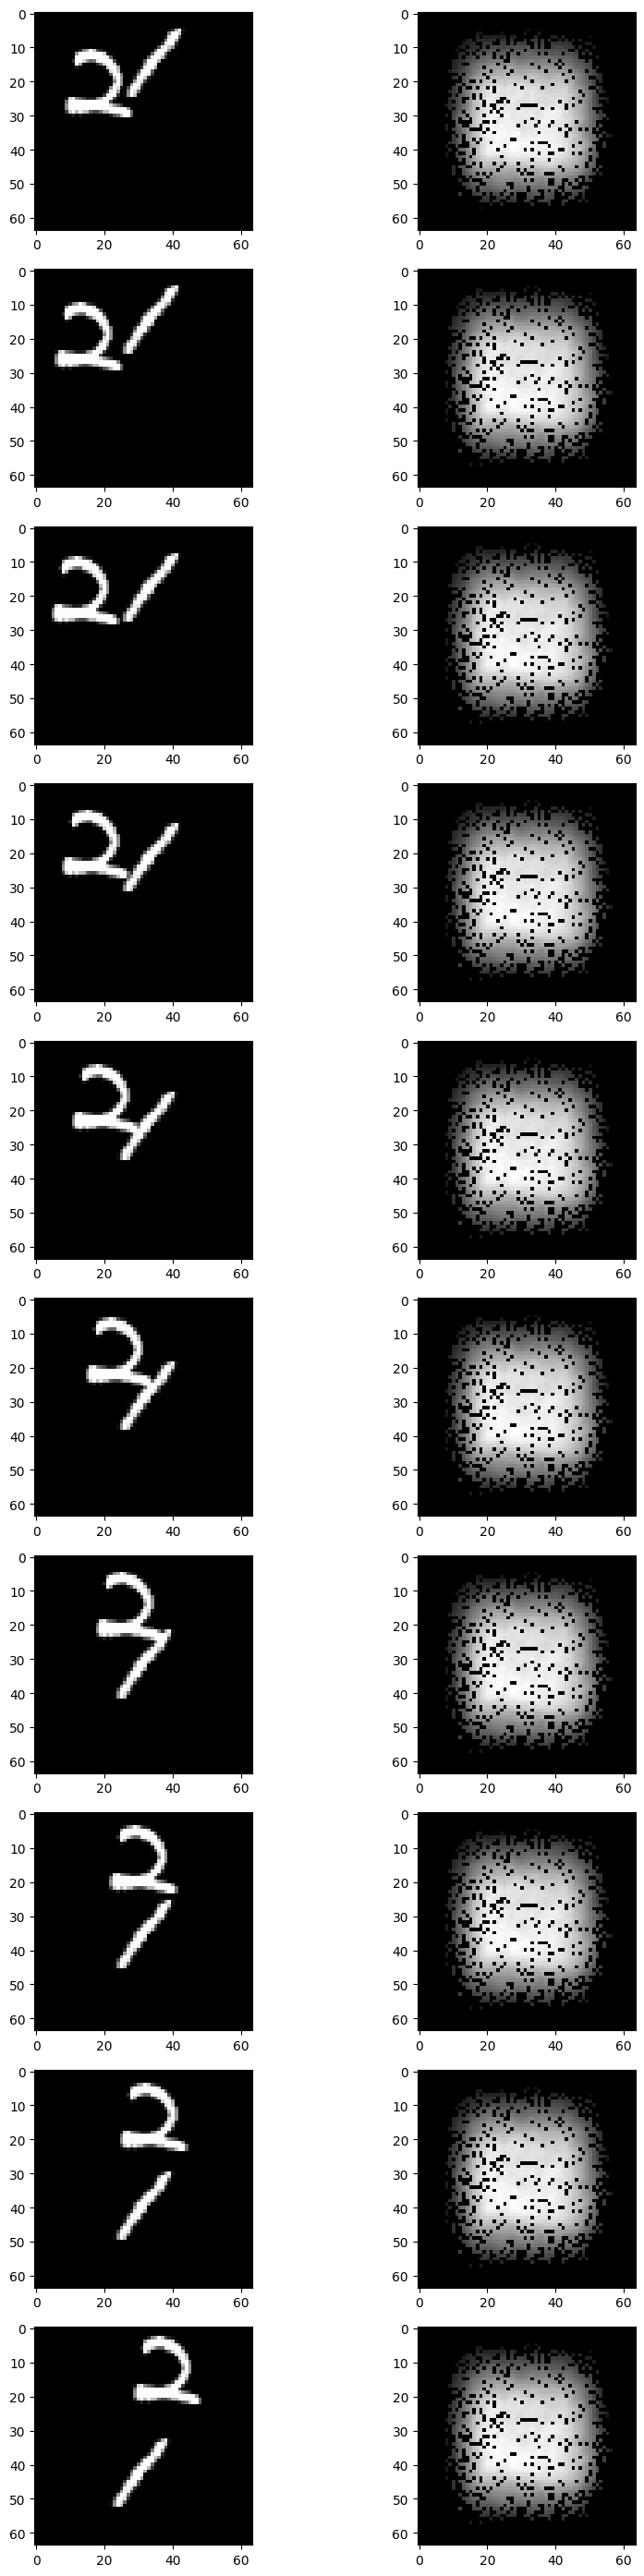

In [51]:
print("Predicted:")
frames = sequence_test['frames'].float()
pred, h = model(frames)
print(pred.shape)
pred = pred.detach()

# full_video = torch.cat((frames, pred), 0)
# visualize_frames(full_video)

f, subplot = plt.subplots(10,2)

for i in range(pred.shape[0]):
    frame_y = gt_frames[i, :, :]
    img_y = frame_y.detach().numpy()
    subplot[i,0].imshow(img_y, cmap='gray', aspect=1)

    frame_x = pred[i, :, :].squeeze(0)
    img_x= frame_x.detach().numpy()
    subplot[i,1].imshow(img_x, cmap='gray',aspect=1)

f.show()

# 2) ConvLSTM

In [ ]:
import src.convLSTM as mod
from src.parameters import CHANNELS

model_2 = mod.PlEncoderDecoder(k_s =3, Batch_size = batch_size)

In [ ]:
trainer.fit(model=model_2, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params
---------------------------------------------
0 | Conv          | Sequential | 10    
1 | Conv_dwsamp   | Sequential | 10    
2 | Deconv        | Sequential | 10    
3 | Deconv_upsamp | Sequential | 40    
4 | lstm          | LSTM       | 526 K 
---------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)
INFO: 
  | Name          | Type       | Params
---------------------------------------------
0 | Conv          | Sequential | 10    
1 | Conv_dwsamp   | Sequential | 10    
2 | Deconv        | Sequential | 10    
3 | Deconv_upsamp | Sequential | 40    
4 | lstm          | LSTM       | 526 K 
---------------------------------------------
526 K     Tra

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.test(model_2, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       2283.55078125       │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2283.55078125}]

## Checkpoint Loading and Visualization  Model 2:

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"

# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)

# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [ ]:
sequence_test = test_set[31]
dataset.visualize(sequence_test['index'])

In [ ]:
#Prediction of frames

frames = sequence_test['frames']

pred = None
h = None
for i in range(frames.shape[0]) :
    frame_i = frames[i, :, :].float()
    pred_f, h = model_2(frame_i, h)
    if i==0:
        pred = pred_f
    else:
        pred = torch.cat((pred,pred_f),1)
print(pred.shape)

torch.Size([1, 10, 64, 64])


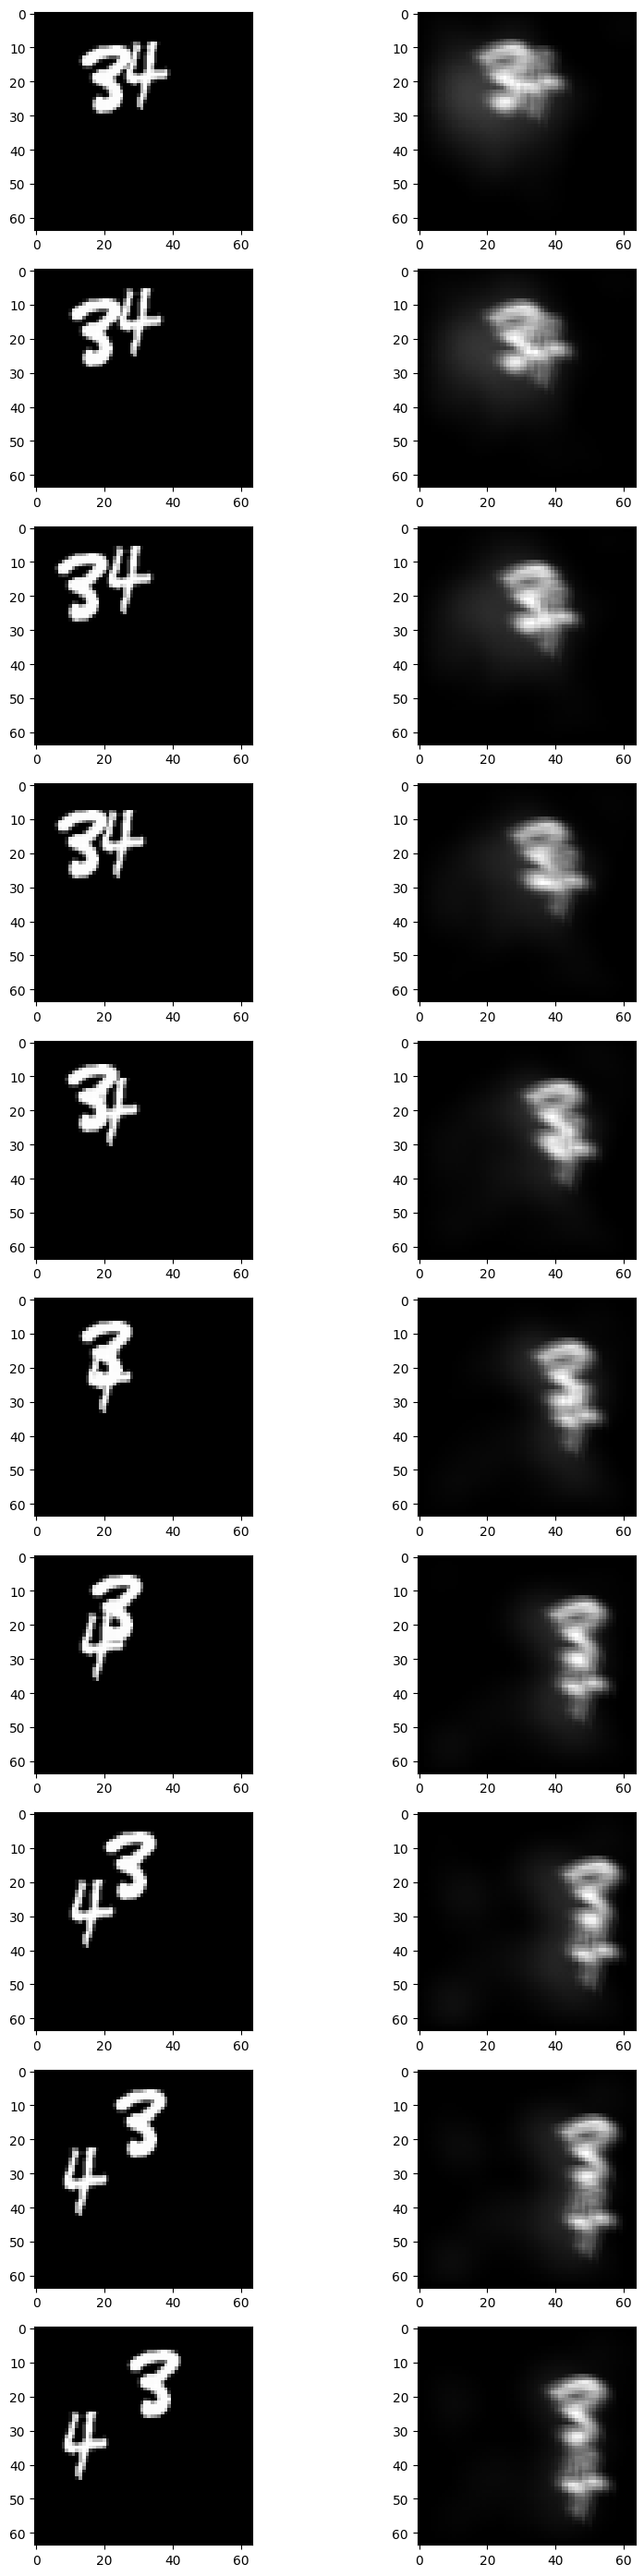

In [ ]:
plt.rcParams["figure.figsize"] = [14.00, 28.00]
plt.rcParams["figure.autolayout"] = True

f, subplot = plt.subplots(10,2)

gt_img = sequence_test['y'].float()

for i in range(gt_img.shape[0]):
    frame_y = gt_img[i, :, :]
    img_y = frame_y.detach().numpy()
    subplot[i,0].imshow(img_y, cmap='gray', aspect =1)

    frame_x = pred[:, 9-i, :, :].squeeze(0)
    img_x= frame_x.detach().numpy()
    subplot[i,1].imshow(img_x, cmap='gray',aspect =1)

f.show()




#frames = sequence_test['frames'].float()

In [ ]:
#GROUND TRUTH

# print("Ground Truth:")
# gt_img = sequence_test['y'].float()
# print(gt_img.shape)


# for i in range(gt_img.shape[0]):
#     frame_i = gt_img[i, :, :]
#     img = frame_i.detach().numpy()
#     plt.imshow(img, cmap='gray')
#     plt.show()

In [ ]:
#PREDICTION

# frames = sequence_test['frames'].float()

# #pred = model_2(frames)
# for i in range(pred.shape[1]):
#     frame_i = pred[:, i, :, :].squeeze(0)
#     img = frame_i.detach().numpy()
#     plt.imshow(img, cmap='gray')
#     plt.show()

In [ ]:
# print("Predicted:")
# pred = pred.squeeze()
# print('PRED SIZE =',pred.size())
# img = pred.detach().numpy()
# print('IMG SIZE = ', img.shape)
# #img = pred.detach().squeeze(0).numpy() # use this line if the previous arises problems
# plt.imshow(img, cmap='gray')
# plt.show()

# 3) ConvTAU

In [ ]:
from src.ConvTAU import *
from src.parameters import ParamsConvTAU

params_3 = ParamsConvTAU()
model_3 = ConvTAU(params_3)

In [ ]:
# trainer.fit(model=model_3, train_dataloaders=training_dataloader)
trainer.fit(model=model_3, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | mse     | MSELoss | 0     
1 | encoder | Encoder | 40    
2 | tau     | TAU     | 690   
3 | decoder | Decoder | 70    
------------------------------------
800       Trainable params
0         Non-trainable params
800       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model_3, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_kl_loss        │   0.0033267114777117968   │
│         test_loss         │     2727.032958984375     │
│       test_mse_loss       │     2727.02978515625      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2727.032958984375,
  'test_mse_loss': 2727.02978515625,
  'test_kl_loss': 0.0033267114777117968}]

## Checkpoint Loading and Visualization Model 3:

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"

# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)

# model_3.load_state_dict(checkpoint['state_dict'])
# model_3.eval()

In [ ]:
print("Input:")
sequence_test = test_set[42]
dataset.visualize(sequence_test['index'])

Input:


In [ ]:
print("Ground Truth:")
gt_frames = sequence_test['y']
visualize_frames(gt_frames)
# full_video = torch.cat((frames, gt_frames), 0)
# visualize_frames(full_video)

Ground Truth:


In [ ]:
print("Prediction:")
frames = sequence_test['frames'].float()
pred = model_3(frames).detach().squeeze(1)
visualize_frames(pred)
# full_video = torch.cat((frames, pred), 0)
# visualize_frames(full_video)

Prediction:


# Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=tensorboard/ #--port 6007

# Remember to save weights (if needed)

In [ ]:
# !zip -r ../logs lightning_logs/

# Extra / Trash

In [ ]:
# import gc
# print(torch.cuda.list_gpu_processes())
# gc.collect()
# torch.cuda.empty_cache()